In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit_ibm_provider import IBMProvider, least_busy
import os
from dotenv import load_dotenv
import pylatexenc
from qiskit.tools.monitor import job_monitor

load_dotenv()

True

# 3SAT Cirucit Construction

This is an optimized version of our general $n$-bit diffuser defined by Qiskit in https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm. 

You can see it on [Quirk](https://algassert.com/quirk#circuit={%22cols%22:[[%22~4jeb%22,%22~3ncq%22,%22~2qcf%22],[%22X^%C2%BD%22,%22X^%C2%BD%22,%22X^%C2%BD%22],[1,1,%22H%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,%22X%22],[1,1,%22H%22],[%22X^-%C2%BD%22,%22X^-%C2%BD%22,%22X^-%C2%BD%22]],%22gates%22:[{%22id%22:%22~4jeb%22,%22name%22:%22q0%22,%22matrix%22:%22{{1,0},{0,1}}%22},{%22id%22:%22~3ncq%22,%22name%22:%22q1%22,%22matrix%22:%22{{1,0},{0,1}}%22},{%22id%22:%22~2qcf%22,%22name%22:%22q2%22,%22matrix%22:%22{{1,0},{0,1}}%22}]}).

In [2]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply Rx gates pi/2
    for qubit in range(nqubits):
        qc.rx((np.pi)/2, qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply Rx gates -pi/2
    for qubit in range(nqubits):
        qc.rx(-(np.pi)/2, qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

We will be looking at the following 3-SAT of 5 clauses
$$
(\neg{v_1} \lor \neg{v_2} \lor \neg{v_3}) \land (v_1 \lor \neg{v_2} \lor v_3) \land (v_1 \lor v_2 \lor \neg{v_3}) \land (v_1 \lor \neg{v_2} \lor \neg{v_3}) \land (\neg{v_1} \lor v_2 \lor v_3)
$$
with solution set expressed as $(v_1, v_2, v_3)$
$$
(T, F, T) = 101\\
(F, F, F) = 000 \\
(T, T, F) = 110 \\
$$

In [3]:
v1, v2, v3 = 1, 2, 3  # Set to positive dummy value to represent a non-negated variable
problem = [(-v1, -v2, -v3), (v1, -v2, v3), (v1, v2, -v3), (v1, -v2, -v3), (-v1, v2, v3)]
problem

[(-1, -2, -3), (1, -2, 3), (1, 2, -3), (1, -2, -3), (-1, 2, 3)]

Then we define our quantum OR, which simulates an OR by flipping all inputs and performing a multi-qubit AND (Toffoli/CCNOT gate) on the output qubit (then flipping back to preserve the original inputs). The output qubit should be initially 1 for it to output the correct answer. You can view/interact with this circuit [here](https://algassert.com/quirk#circuit={%22cols%22:[[%22~sb6e%22,%22~tigb%22,%22~k19d%22,%22~gt47%22],[%22X%22,%22X%22,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,%22%E2%80%A2%22,%22X%22],[%22X%22,%22X%22,%22X%22]],%22gates%22:[{%22id%22:%22~sb6e%22,%22name%22:%22a%22,%22matrix%22:%22{{1,0},{0,1}}%22},{%22id%22:%22~tigb%22,%22name%22:%22b%22,%22matrix%22:%22{{1,0},{0,1}}%22},{%22id%22:%22~k19d%22,%22name%22:%22c%22,%22matrix%22:%22{{1,0},{0,1}}%22},{%22id%22:%22~gt47%22,%22name%22:%22out%22,%22matrix%22:%22{{1,0},{0,1}}%22}],%22init%22:[0,0,0,1]}).

In [4]:
# Define quantum OR
def OR(qc, vars, out):
    # Invert all inputs
    qc.x(vars[0])
    qc.x(vars[1])
    qc.x(vars[2])

    # Compute AND
    qc.mct(vars, out)

    # Flip back to original inputs
    qc.x(vars[0])
    qc.x(vars[1])
    qc.x(vars[2])

Next we define a function to add a clause to from the 3-SAT statement to our circuit. Since all clauses consist of (intact or negated) variables in an OR, we negate variables with an X gate where applicable, and apply our previously mentioned OR gate. Negated variables are defined in the `clause` parameter, where a negative number means the given variable is negated.

In [5]:
def add_clause(qc, clause, var_qubits, clause_qubit):
    # Flip the clause statement because qiskit orders qubits in reverse
    clause = clause[::-1]

    # Apply NOT gates to all variables that are negated in this clause
    for i in range(len(clause)):
        if clause[i] < 0:
            qc.x(var_qubits[i])

    # Apply OR flipper
    OR(qc, var_qubits, clause_qubit)

    # Uncompute NOT gates
    for i in range(len(clause)):
        if clause[i] < 0:
            qc.x(var_qubits[i])

Finally, we initialize define our circuit building and add the clauses.

In [6]:
# Initialize circuit
var_qubits = QuantumRegister(3, name='v')    # One qubit per variable
clause_qubits = QuantumRegister(5, name='c') # One cubit per clause
out_qubit = QuantumRegister(1, name='out')   # Used to write output of clauses
cbits = ClassicalRegister(3, name='cbits')   # Three classical bits for output

qc = QuantumCircuit(var_qubits, clause_qubits, out_qubit, cbits)

# Initialize 'out' in state |->
qc.initialize([1, -1]/np.sqrt(2), out_qubit)

# Initialize with Rx gates
qc.rx((np.pi/2), var_qubits)

# Initialize clause qubits to |1>
# The OR flipper will flip them to back 0/false if all the inputs are 0/false
qc.initialize([0, 1], clause_qubits[0])
qc.initialize([0, 1], clause_qubits[1])
qc.initialize([0, 1], clause_qubits[2])
qc.initialize([0, 1], clause_qubits[3])
qc.initialize([0, 1], clause_qubits[4])

qc.barrier()  # for visual separation

In [7]:
# Add the first clause ( -v1 OR -v2 OR -v3 )
add_clause(qc, problem[0], var_qubits, clause_qubits[0])

# Add second clause (v1 OR -v2 OR v3)
add_clause(qc, problem[1], var_qubits, clause_qubits[1])

# Add third clause (v1 OR v2 OR -v3)
add_clause(qc, problem[2], var_qubits, clause_qubits[2])

# Add fourth clause (v1 OR -v2 OR -v3)
add_clause(qc, problem[3], var_qubits, clause_qubits[3])

# Add fifth clause (-v1 OR v2 OR v3)
add_clause(qc, problem[4], var_qubits, clause_qubits[4])

# Flip output if all clauses are satisfied
qc.mct(clause_qubits, out_qubit)

qc.barrier()

# Uncompute clauses to reset clause-checking bits to 0
add_clause(qc, problem[0], var_qubits, clause_qubits[0])
add_clause(qc, problem[1], var_qubits, clause_qubits[1])
add_clause(qc, problem[2], var_qubits, clause_qubits[2])
add_clause(qc, problem[3], var_qubits, clause_qubits[3])
add_clause(qc, problem[4], var_qubits, clause_qubits[4])

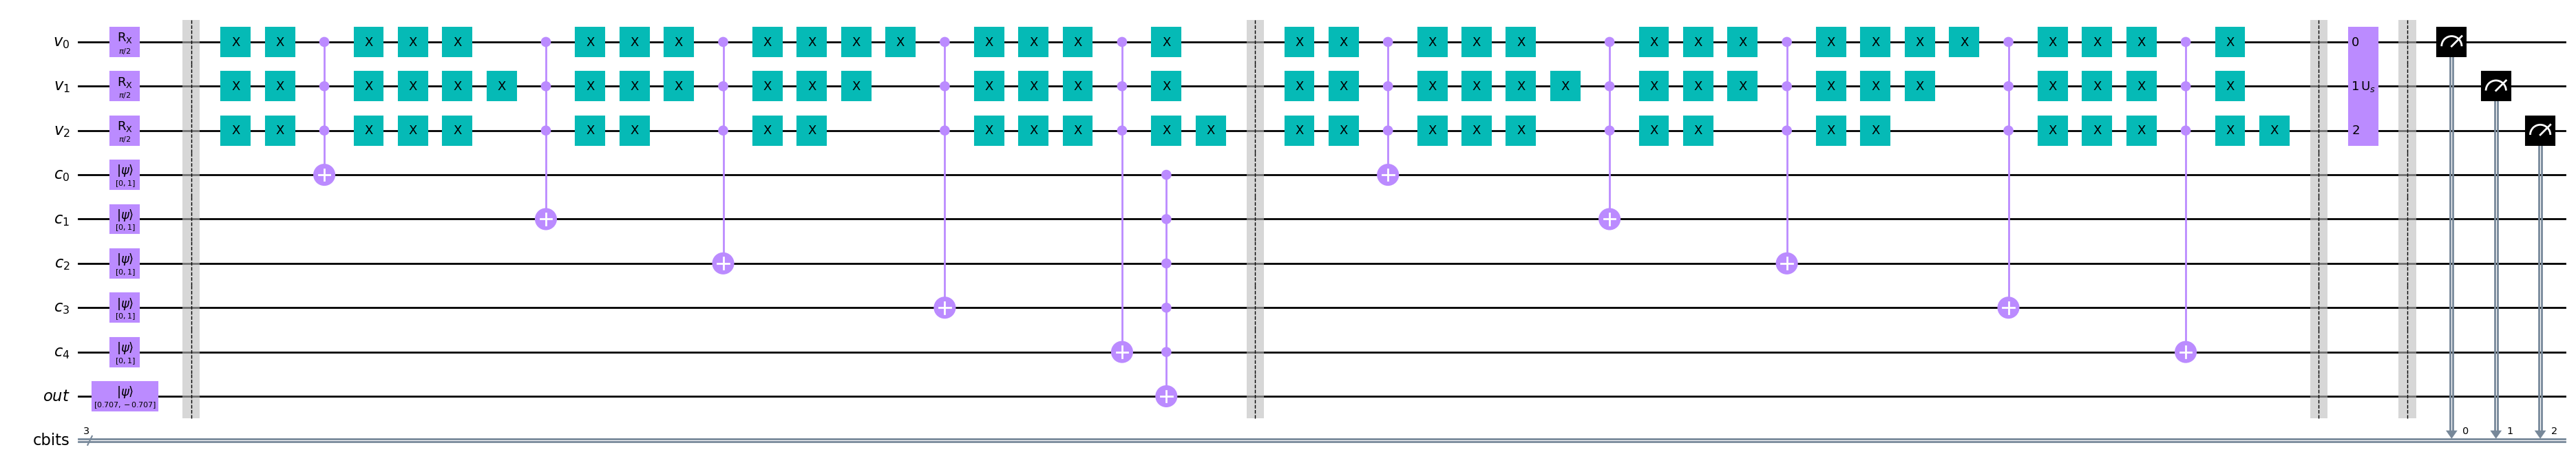

In [8]:
# Append diffuser
qc.barrier()
qc.append(diffuser(3), [0,1,2])
qc.barrier()

# Perform measurement
qc.measure(var_qubits, cbits)
qc.draw(output='mpl', fold=-1)

25


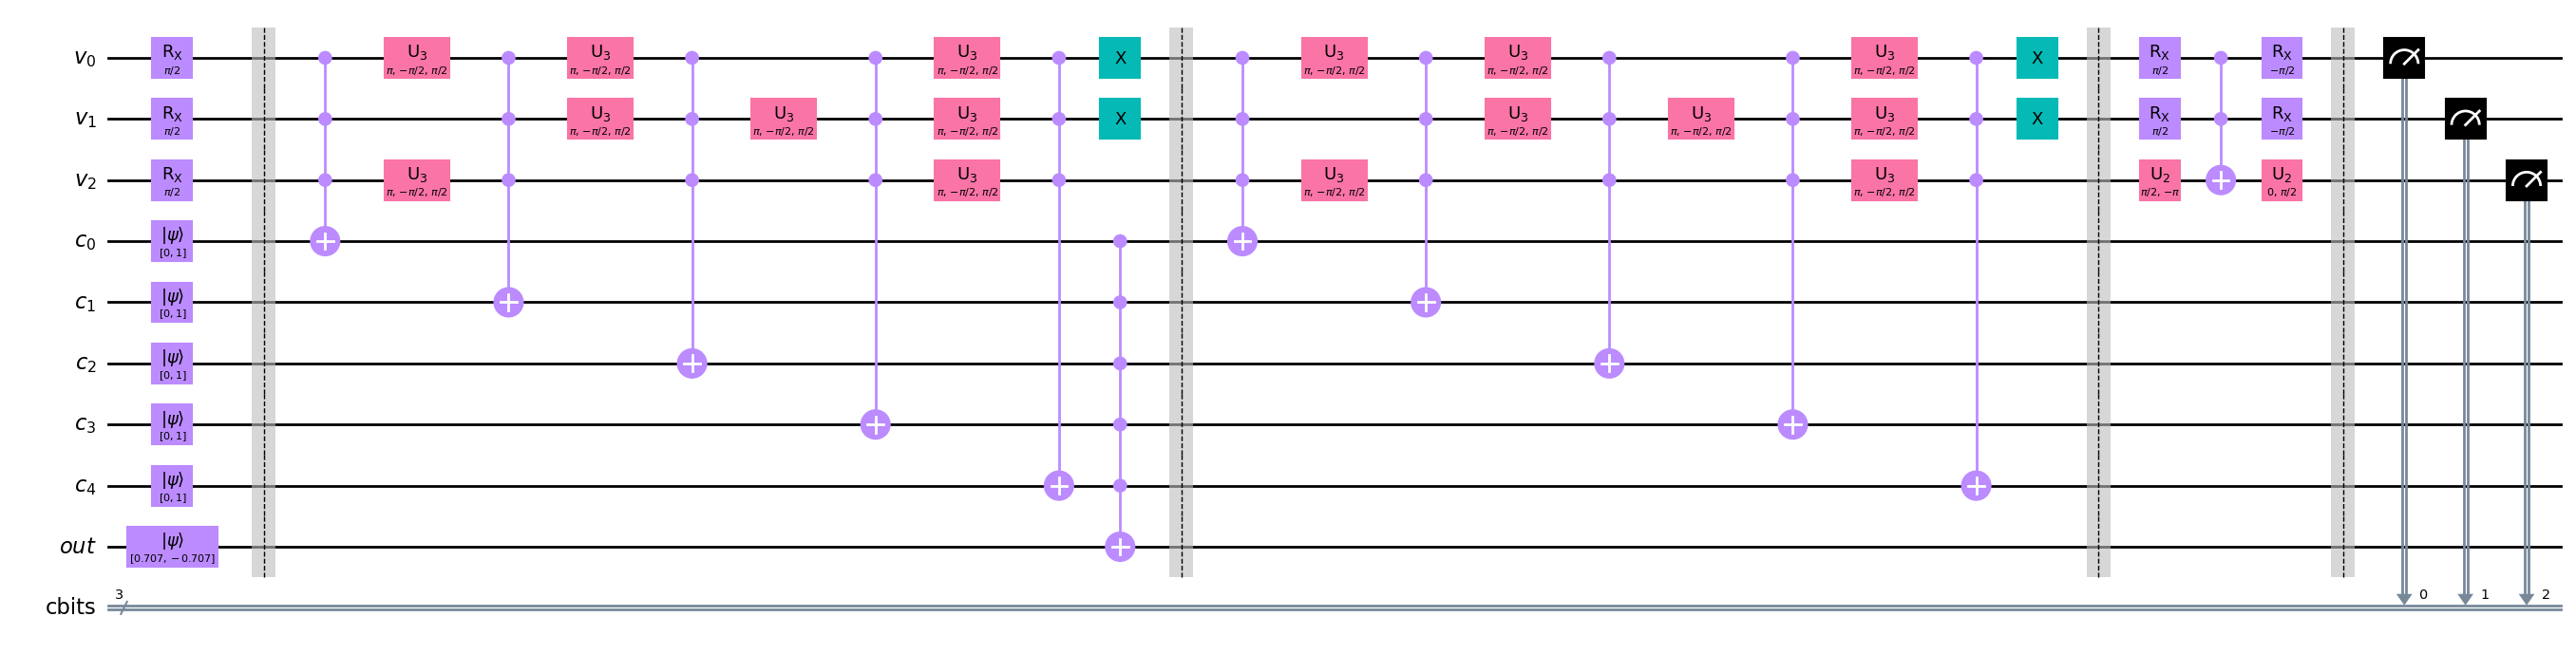

In [9]:
# Run on simulator
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
print(transpiled_qc.depth())
transpiled_qc.draw(output='mpl', fold=-1)

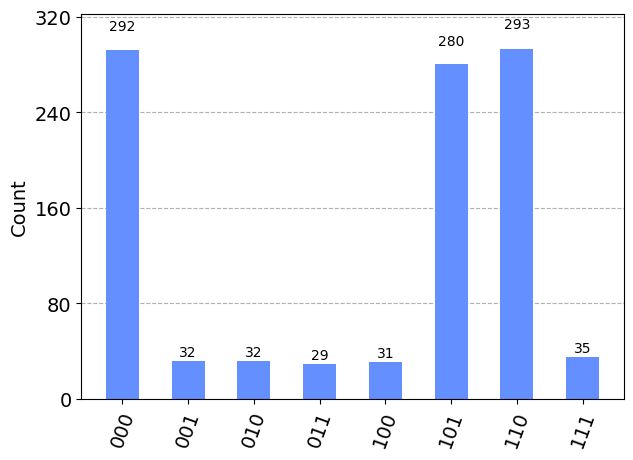

In [10]:
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

# General 3SAT Circuit Constructing 

In [13]:
def SAT_circuit(problem, iterations=1):
    # Find number of variables
    var_count = max( [ max(abs(x) for x in clause) for clause in problem ] )

    var_qubits = QuantumRegister(var_count, name='v')    # One qubit per variable
    clause_qubits = QuantumRegister(len(problem), name='c') # One cubit per clause
    out_qubit = QuantumRegister(1, name='out')   # Used to write output of clauses
    cbits = ClassicalRegister(var_count, name='cbits')   # One classical bits per variable for output

    qc = QuantumCircuit(var_qubits, clause_qubits, out_qubit, cbits)

    # Initialize 'out' in state |->
    qc.initialize([1, -1]/np.sqrt(2), out_qubit)

    # Initialize with Rx gates
    qc.rx((np.pi/2), var_qubits)

    # Initialize clause qubits to |1>
    # The OR flipper will flip them to back 0/false if all the inputs are 0/false
    for qubit in clause_qubits:
        qc.initialize([0, 1], qubit)

    qc.barrier()  # for visual separation

    for i in range(iterations):
        # Add clauses
        for i in range(len(problem)):
            clause = problem[i]
            qubits = [var_qubits[abs(x)-1] for x in clause]
            add_clause(qc, clause, qubits, clause_qubits[i])
        
        # Flip output if all clauses are satisfied
        qc.mct(clause_qubits, out_qubit)

        qc.barrier()

        # Uncompute clauses to reset clause-checking bits to 1
        for i in range(len(problem)):
            clause = problem[i]
            qubits = [var_qubits[abs(x)-1] for x in clause]
            add_clause(qc, clause, qubits, clause_qubits[i])
        
        # Append diffuser
        qc.barrier()
        qc.append(diffuser(var_count), range(var_count))
        qc.barrier()
    
    qc.measure(var_qubits, cbits)

    return qc

# Simulator Results

## 1. Observations based on amout of iterations on simulator

Problem:
$$
(\neg{v_1} \lor \neg{v_2} \lor \neg{v_3}) \land (v_1 \lor \neg{v_2} \lor v_3) \land (v_1 \lor v_2 \lor \neg{v_3}) \land (v_1 \lor \neg{v_2} \lor \neg{v_3}) \land (\neg{v_1} \lor v_2 \lor v_3)
$$
Solutions:
$$
(T, F, T) = 101\\
(F, F, F) = 000 \\
(T, T, F) = 110 \\
$$

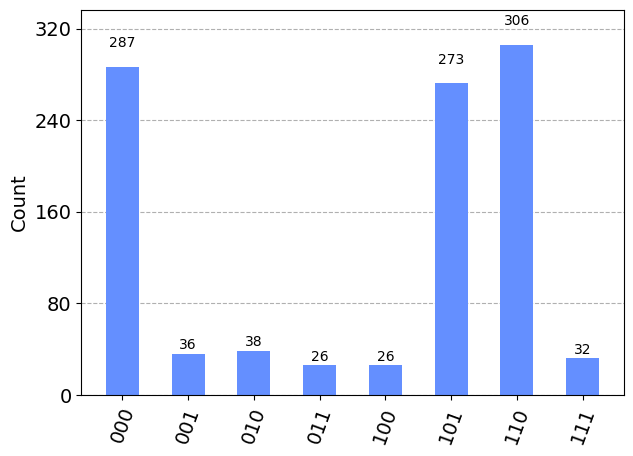

In [15]:
v1, v2, v3 = range(1, 4)  # Set to positive dummy value to represent a non-negated variable
problem = [(-v1, -v2, -v3), (v1, -v2, v3), (v1, v2, -v3), (v1, -v2, -v3), (-v1, v2, v3)]

# Specify the number of iterations
iterations = 1
qc = SAT_circuit(problem, iterations)
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

## 2. Observations based on amout of iterations on real device

In [57]:
# Connect account to run on real device
provider = IBMProvider(token=os.getenv('IBMQ_API_TOKEN'))

problem = [(-v1, -v2, -v3), (v1, -v2, v3), (v1, v2, -v3)]
qc = SAT_circuit(problem, iterations=3)

# Select least busy available backend
filtered_backends = provider.backends(simulator=False, operational=True, min_num_qubits=qc.num_qubits)
least_busy_backend = least_busy(filtered_backends)

print(filtered_backends)
print(least_busy_backend)

device = provider.get_backend(least_busy_backend.name)

transpiled_qc = transpile(qc, device, optimization_level=3)

print(f"Backend: {device.name} v{device.backend_version}")
print(f"Depth: {transpiled_qc.depth()}")
print(f"{device.num_qubits} qubits")
print(f"Pending jobs: {device.status().pending_jobs}")

[<IBMBackend('ibmq_kolkata')>, <IBMBackend('ibm_cairo')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibm_cusco')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_algiers')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_nazca')>, <IBMBackend('ibm_kyoto')>]
<IBMBackend('ibm_osaka')>


/Users/kmsi/Development/CSC591/venvs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/kmsi/Development/CSC591/venvs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/kmsi/Development/CSC591/venvs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/kmsi/Development/CSC591/venvs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/kmsi/Development/CSC591/venvs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/U

Backend: ibm_osaka v1.0.0
Depth: 3240
127 qubits
Pending jobs: 0


In [56]:
job_1 = device.run(transpiled_qc)
job_monitor(job_1)

KeyError: 16

In [ ]:
job = device.run(transpiled_qc)

In [47]:
job_monitor(job)

Job Status: job is queued

KeyboardInterrupt: 

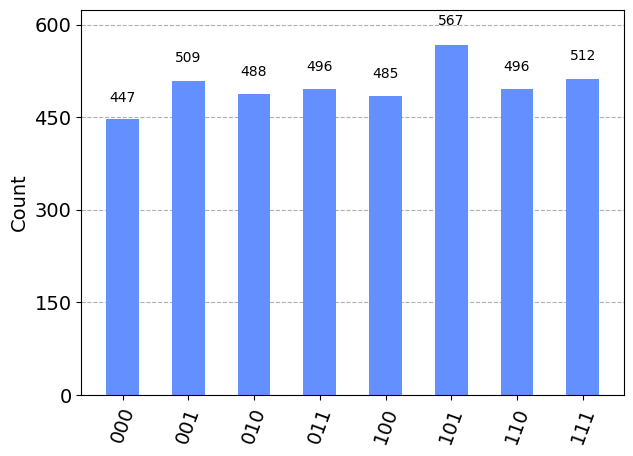

In [16]:
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts)

## 2. Observations based on amount of clauses

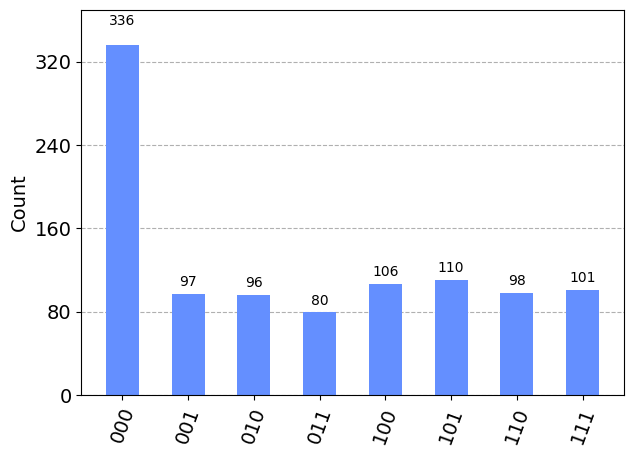

In [43]:
v1, v2, v3 = range(1, 4)
full_problem = [(-v1, -v2, -v3), (v1, -v2, v3), (v1, v2, -v3), (v1, -v2, -v3), (-v1, v2, v3), (-v1, -v2, v3), (-v1, v2, -v3)]

# Specify number of clauses to use
clauses = 5
problem = full_problem[:clauses]

print(problem)

qc = SAT_circuit(problem, iterations=3)
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

In [ ]:
# Connect account to run on real device
provider = IBMProvider(token=os.getenv('IBMQ_API_TOKEN'))

In [ ]:
print(provider.active_account()['instance'])

# Select least busy available backend
filtered_backends = provider.backends(simulator=False, operational=True, min_num_qubits=qc.num_qubits)
least_busy_backend = least_busy(filtered_backends)

print(filtered_backends)
print(least_busy_backend)

In [ ]:
# Find the device with the least circuit depth
min = 100000 # Arbitrary large number
min_device = 0
for backend in filtered_backends:
    device = provider.get_backend(backend.name)
    transpiled_qc = transpile(qc, device, optimization_level=3)
    if transpiled_qc.depth() < min:
        min = transpiled_qc.depth()
        min_device = device

In [ ]:
device = min_device
# device = provider.get_backend(least_busy_backend.name)

print(f"Backend: {device.name} v{device.backend_version}")
print(f"Depth: {transpiled_qc.depth()}")
print(f"{device.num_qubits} qubits")
print(f"Pending jobs: {device.status().pending_jobs}")

In [ ]:
transpiled_qc = transpile(qc, device)
print(transpiled_qc.depth())

In [ ]:
from qiskit.tools.monitor import job_monitor
job = device.run(transpiled_qc)
job_monitor(job)

In [ ]:
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts)